In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import skew
from scipy.optimize import curve_fit

import collections

from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.base import clone

In [2]:
# Utility functions:
def count_missing_values(data):
    n_rows = data.shape[0]
    for column in data.columns:
        nan_count = data[column].isna().sum()
        if nan_count > 0:
            print('Column {} has {}/{} missing values'.format(column, nan_count, n_rows))

In [3]:
train = pd.read_csv('data//tesco-dataset//train.csv')
test_masked = pd.read_csv('data//tesco-dataset//test.csv')

#The 'locaction_id' is unique for each instance so I reindex the data frame rows with location_id:
train.set_index('location_id', inplace=True)
test_masked.set_index('location_id', inplace=True)

# Exploring data

In [4]:
# Look for missing features in the training set:
count_missing_values(train)

Column commercial_property has 29/320 missing values
Column school_proximity has 63/320 missing values


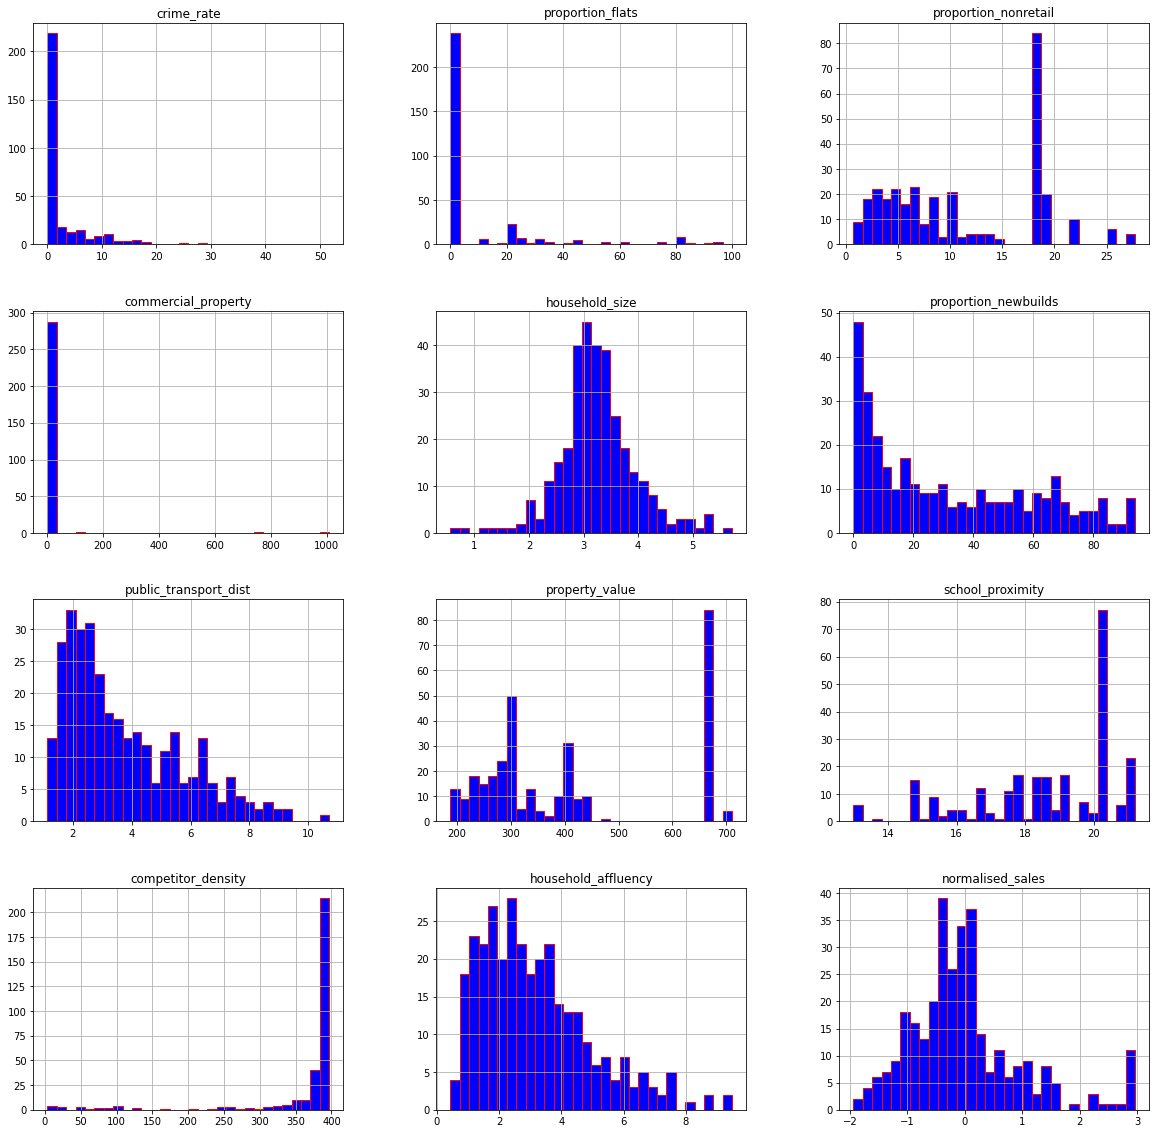

In [5]:
#Plot out the distributions of numerical feature values:
pl = train.hist(figsize=(20,20), bins=30, color='blue', ec='red')

Text(0.5, 1.0, 'New store counts')

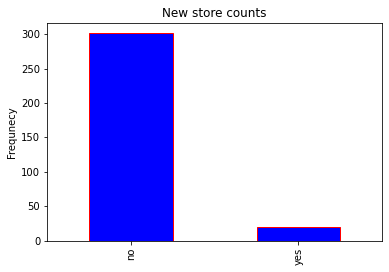

In [6]:
#Plot the distribution of 'new_store' values:
ax = train['new_store'].value_counts().plot(kind='bar', color='blue', ec='red')
ax.set_ylabel('Frequnecy')
ax.set_title('New store counts')

Text(0.5, 1.0, 'Transport availability counts')

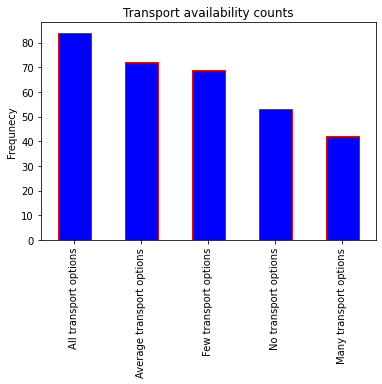

In [7]:
#Plot the distribution of 'transport_availability' values:
ax = train['transport_availability'].value_counts().plot(kind='bar', color='blue', ec='red')
ax.set_ylabel('Frequnecy')
ax.set_title('Transport availability counts')

Text(0.5, 1.0, 'Mean normalised sales for different transport availabilities')

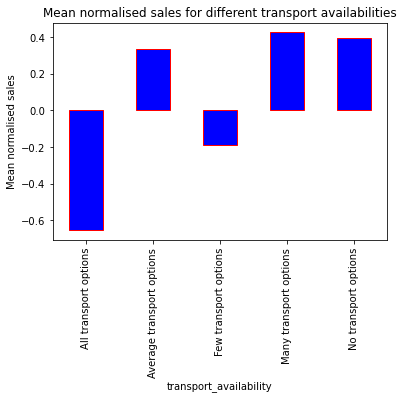

In [8]:
# Check if 'transport_availability' correlates with mean normalised sales:
ax = train.groupby('transport_availability')['normalised_sales'].mean().plot(kind='bar', color='blue', ec='red')
ax.set_ylabel('Mean normalised sales')
ax.set_title('Mean normalised sales for different transport availabilities')

Text(0, 0.5, 'Numeber of stores')

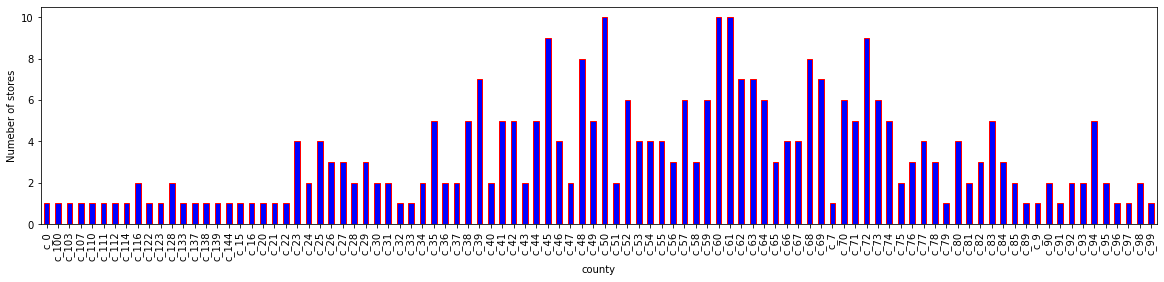

In [9]:
# Plot number of stores per county:
ax = train.groupby('county')['normalised_sales'].count().plot(kind='bar', figsize=(20,4), color='blue', ec='red')
ax.set_ylabel('Numeber of stores')

<AxesSubplot:>

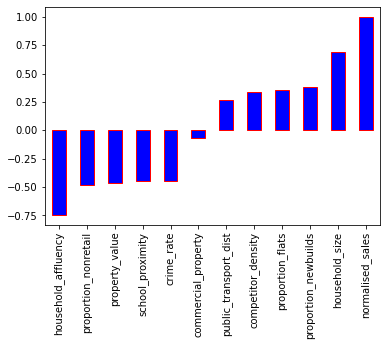

In [10]:
# Correlation matrix and correlation coefficients for target variable:
corr_m = train.corr()
corr_m['normalised_sales'].sort_values().plot(kind='bar', color='blue', ec='red')

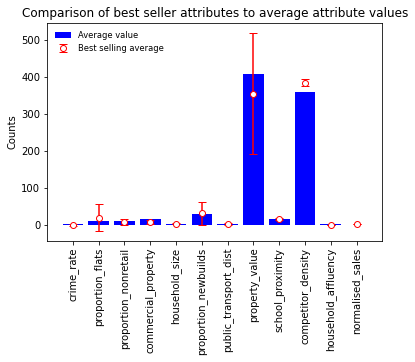

In [11]:
# What makes a store a high seller? Here I compare the average attribute values of the entire data set with the stores which
# highest normalised sales (> 2)

mean_high_earners, std_high_earners = (dict((train[train['normalised_sales'] > 2].mean())),
                                       dict(train[train['normalised_sales'] > 2].std()))
mean_total, std_total = dict(train.mean()), dict(train.std())

fig, ax = plt.subplots(1,1,figsize=(6,4))

n = len(list(mean_total.keys()))

plot = ax.bar(list(mean_total.keys()), list(mean_total.values()), align='center', color='blue', label='Average value')
plot = ax.errorbar(np.arange(n), list(mean_high_earners.values()), yerr=list(std_high_earners.values()), 
            linestyle = '', capsize=4, color='red', marker='o', markerfacecolor = 'white', label='Best selling average')
plot = plt.xticks(rotation='vertical')
plot = ax.set_ylabel('Counts')
plot = ax.set_title('Comparison of best seller attributes to average attribute values')
legend = ax.legend(loc='upper left', shadow=False,fontsize='small',frameon=False)

Text(0, 0.5, 'normalised_sales')

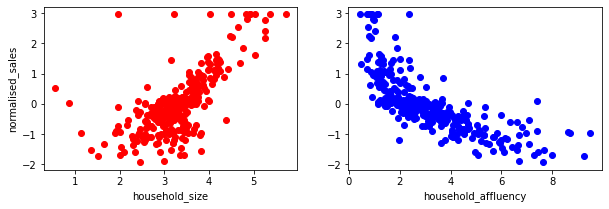

In [12]:
# Scatter plots of features with two highest correleation coefficients with the target variable:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].scatter(train['household_size'], train['normalised_sales'], color='red')
ax[1].scatter(train['household_affluency'], train['normalised_sales'], color='blue')
ax[0].set_xlabel('household_size')
ax[1].set_xlabel('household_affluency')
ax[0].set_ylabel('normalised_sales')

Correlation coefficient between household affluency and property value is 0.5427881806319436


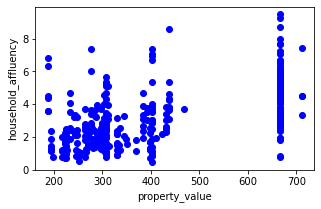

In [13]:
# Plot household aflluency vs property value to look at the correlation between the two:
fig, ax = plt.subplots(1, 1, figsize=(5,3))
ax.scatter(train['property_value'], train['household_affluency'], color='blue')
ax.set_xlabel('property_value')
ax.set_ylabel('household_affluency')
print('Correlation coefficient between household affluency and property value is {}'.
      format(corr_m['household_affluency'].loc['property_value']))

Correlation coefficient between competitor density and normalised sales is 0.3382836271121088


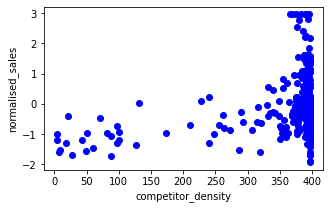

In [14]:
# Plot competitor density vs property value to look at the correlation between the two:
fig, ax = plt.subplots(1, 1, figsize=(5,3))
ax.scatter(train['competitor_density'], train['normalised_sales'], color='blue')
ax.set_xlabel('competitor_density')
ax.set_ylabel('normalised_sales')
print('Correlation coefficient between competitor density and normalised sales is {}'.
      format(corr_m['competitor_density'].loc['normalised_sales']))

# Q1

**Initial basic observations:**
- 12 numerical features and 3 categorical features (new_store, transport_availability, county);
- Column 'commercial_property' has 29/320 missing values, column 'school_proximity' has 63/320 missing values.
- There are 98 unique counties represented by the data set. There are 48 in England so it may be that the data includes international stores. In that case I am not sure what the target value represents because different counties may have different payment currencies.
- The distribution of target values 'normalized sales' seems to be somewhat skewed. Have to remember that when sampling the data during training.
- Column 'commercial_property' likely has a few outliers. The values should range between 0-100 because they represent a percentage. I see a few values well above 100, which I will deal with later.

**Some qualitative/quantitavive observations (based on the assumption that training samples are statistically representative):**
- The household affluency ranges between 0-10. Most Tesco stores are in areas with an average affluency of ~2. This suggests that Tesco offers more affordable prices which are more attractive to lower than median income households. Nevertheless, locations of Tesco stores cover areas with a wide range of average property values. Property value is, of course, not necessarily represantive of household affluency- property prices have changed rapidly over the last couple of decades thus less affluent households could of afforded property which is substantially more expensive now then it was some years ago. In fact, this argument is supported by a low correlation between household affluency and property value.
- The highest selling stores seem to be located in areas with high competitor density. This seems reasonable as high competitor density areas should correlate positively with high available customer numners.
- Based on the data provided, most Tesco stores are in low crime areas with a large portion of newly built property and close to public transport.
- The normalised sales exhibits significant positve correlation with household size and a negative correlation with affluency. The former suggests that larger families prefare to shop at Tesco and spend more while the latter supports the first point above, that more affluent households tend to shop elsewhere.
- Most Tesco stores are in areas with a large density of comptetitors. This is intuitive, as areas with higher traffic and thus more customers will have more shops.
- Average normalised sales seems to correlate with number of stores in a given county. This may serve as a potential 'encoding' of the categorical attribute 'county'.

**Data for future developments:**
- Get number of Sainsbury's, M and S, Waitrose, Lidl, etc. stores in the proximity of each Tesco store. If possible, also get the average sales for each competitor at the corresponding locations. This data would allow to look more closely at customer segmentation and potentially spot more attractive locations for a new Tesco store.
- A few interesting features to look at would be: the duration a store has been opened for, availability of car parking next to the store.
- Would be good to know the size of each store. Or are the normalised sales normalised relative to the store size?


# Split to training and test sets (Q2)

In [15]:
# Rearange order of columns in the data frame: first numerical features followed by the categorical.
numerical_cols = list(train._get_numeric_data().columns)
categorical_cols = list(train.select_dtypes(include=['object']).columns)
new_order_train = (numerical_cols + categorical_cols)
new_oder_test_masked = new_order_train.copy()
new_oder_test_masked.remove('normalised_sales')
train = train[new_order_train]
test_masked = test_masked[new_oder_test_masked]

In [16]:
# First separate out the independent (features) and dependent (target) variables. Then create a holdout test set to be used
# for later evaluation of model performance.
X, Y = train.drop('normalised_sales', axis=1), train['normalised_sales']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=12)

# Remove target feature from numerical column names list:
if 'normalised_sales' in numerical_cols:
    numerical_cols.remove('normalised_sales')

# Dealing with missing values and outliers (Q2)

- There are two columns with missing values. 'school_proximity': missing values may correspond to instances where there is no school in the proximity of the store. If that is true, replacing these with some value which is greater than the largest recorded distance might work well. Other option is to impute the mean distance. 'commercial_property' missing  values are likely due to lack of information for those instances: zero values do exist so a missing value probably does not mean there are no commercial properties. I will replace these with the mean value.

- I write my own custom transformers so that they are compatible with scikit's pipelines.

In [17]:
class CustomImputer(BaseEstimator, TransformerMixin):
    """
    Find missing values in column 'commercial_property' and replaces them with mean value. Can also check that percentage
    values make sense: if value is larger than 100, replace it with mean.
    Also, find missing values in column 'school_proximity' and replaces them with a preset value.
    
    Parameters
    ----------
    fix_percentages: default=True. If True replace percentages which are > 100 with mean.
    school_distance: default=50. Value with which to replace missig entries in school_proximity.
    cp_i: default=3; index of the colum corresponding to 'commercial_property'.
    sp_i: default=8; index of the colum corresponding to 'school_proximity'.
    """
    
    def __init__(self, 
                 fix_percentages=True,
                 school_distance=50.0,
                 cp_i=3,
                 sp_i = 8):
        self.fix_percentages = fix_percentages
        self.school_distance = school_distance
        self.cp_i = cp_i
        self.sp_i = sp_i
        
        self._mean = float
        
    def fit(self, X, Y=None):
        """
        Method for finding the mean of the column. Mean ignores suspicious values (>100) in 'commercial_property'.
        """
        X = np.array(X)
        commercial_properties = X[:, self.cp_i].astype(float)
        lm = commercial_properties[~np.isnan(commercial_properties)]
        lm = lm[~(lm > 100.0)]
        self._mean = lm.mean()
        return self
    
    def transform(self, X):
        X = np.array(X)
        commercial_properties = X[:, self.cp_i].astype(float)
        school_proximities = X[:, self.sp_i].astype(float)
        if self.fix_percentages:
            commercial_properties[np.isnan(commercial_properties)] = self._mean
            commercial_properties[commercial_properties > 100] = self._mean
        else:
            commercial_properties[np.isnan(commercial_properties)] = self._mean
        X[:, self.cp_i] = commercial_properties
        
        school_proximities[np.isnan(school_proximities)] = self.school_distance
        X[:, self.sp_i] = school_proximities
        
        return X

# Encoding categorical features (Q2)

- I encode the categorical features 'transport_availability' and 'new_store' using ordinal encoding. For 'transport_availability': 0 is 'No transport options' and 4 is 'All transport options'. This seems like a logical encoding as 'No transport options' < All transport options. For 'new_store': 'no' is 0, 'yes' is 1.

- The categorical feature 'county' has 98 unique categories. A large fraction of counties have only a single store. Thus it does not seem likely that a county code will be representative of the expected sales. In addition, the algorithm would now know how to deal with new county instances. Instead I replace this feature with the number of stores in a particular county. The custom encoder is below...

In [18]:
class CountyEncoder(BaseEstimator, TransformerMixin):
    """
    Replaces the county column with the number of stores in the county. 
    """
    
    def __init__(self,
                encode=True):
        self.encode = encode
        
        self._county_counts = dict()
        
    def fit(self, X, Y=None):
        return self
    
    def transform(self, X):
        counties = np.array(X)
        u_counties, count_counties = np.unique(counties, return_counts=True)
        county_counts = dict(zip(u_counties, count_counties))
        self._county_counts = collections.Counter(county_counts) + collections.Counter(self._county_counts)
        mp = np.vectorize(lambda c: self._county_counts[c])
        counties = mp(counties)
        return counties

In [19]:
# Build combined pipeline to transform and encode numerical and categorical features.

transport_categories = ['No transport options',
 'Few transport options',
 'Average transport options',
 'Many transport options',
 'All transport options']

store_categories = ['no', 'yes']

ordinal_cols = ['new_store', 'transport_availability']


n_pipeline = Pipeline([
    ('custom_imputer', CustomImputer()),
    ('simple_imputer', SimpleImputer())
])

combined_pipeline = ColumnTransformer([
    ('numerical', n_pipeline, numerical_cols),
    ('ordinal', OrdinalEncoder(categories=[store_categories, transport_categories]), ordinal_cols),
    ('categorical_county', CountyEncoder(), ['county'])
])

In [20]:
# List of all features:
all_features = numerical_cols + ordinal_cols + ['stores_in_county']

In [21]:
# Transform the train, test and masked test sets:
data_train = combined_pipeline.fit_transform(X_train)
data_test = combined_pipeline.transform(X_test)
data_masked = combined_pipeline.transform(test_masked)

In [22]:
# Randomized search of optimal hyperparameters for the random forest regressor. (Takes a couple of minutes to run!).
regr = RandomForestRegressor()

distributions = {'n_estimators': np.arange(10, 500, 30),
                'max_depth': np.arange(5, 300, 20),
                'min_samples_split': np.arange(2, 10, 1),
                'min_samples_leaf': np.arange(1, 20, 1),
                'min_weight_fraction_leaf': np.arange(0.0, 0.2, 0.01)}

regress = RandomizedSearchCV(regr, distributions, cv=5, scoring='neg_mean_squared_error', n_iter=50)

search_regr = regress.fit(data_train, y_train)

In [23]:
regr = search_regr.best_estimator_
regr.fit(data_train, y_train)

RandomForestRegressor(max_depth=265, min_samples_leaf=3, min_samples_split=8,
                      n_estimators=40)

In [24]:
# Evaluate model by computing the root mean squared error and R^2:
predictions = regr.predict(data_test)
mse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print('Test set rmse score is {}, R^2 score is {}'.format(mse, r2))

Test set rmse score is 0.33661225576812703, R^2 score is 0.8570359338047358


(-2.0, 3.0)

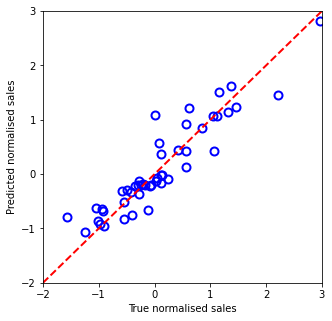

In [25]:
# Plot predicitons vs true normalized sales in the holdout test set: 
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(y_test, predictions, linestyle='', color='blue', marker='o', fillstyle='none', markersize=8, markeredgewidth=2.0)
ax.plot(np.arange(-2,3.1,0.5), np.arange(-2,3.1,0.5), color='red', linestyle='--', linewidth=2.0)
ax.set_xlabel('True normalised sales')
ax.set_ylabel('Predicted normalised sales')
ax.set_xlim([-2,3])
ax.set_ylim([-2,3])

In [26]:
# Lets get a better estimate of model performance using cross_validation. Here I train the model on the full data set

data_train_full = combined_pipeline.fit_transform(X) # prepare the entire data set for training

scores = cross_val_score(regr, data_train_full, Y,
                         scoring='neg_mean_squared_error', cv=15)
tree_scores = np.sqrt(-scores)
print('Cross validation rmse score is {} +/- {}'.format(tree_scores.mean(), tree_scores.std()))

#Refit model for later use:
regr.fit(data_train_full, Y)

Cross validation rmse score is 0.369280911458612 +/- 0.16030043385857667


RandomForestRegressor(max_depth=265, min_samples_leaf=3, min_samples_split=8,
                      n_estimators=40)

# Classification of profitable and detrimental stores (Q2 and Q3)

I also partition the normalised sales into 2 categories to better address the question: **Should a new store be opened in this area?**.
The categories are 'detrimental_store', 'profitable_store'. I then fit a random forests classifier with these two categories as the target variable.

In [27]:
Y_categorical = pd.cut(train['normalised_sales'], bins=[-2, 0.005, 3],
                       labels=['detrimental_store', 'profitable_store'])

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, Y_categorical, test_size=0.15, random_state=12)

<AxesSubplot:>

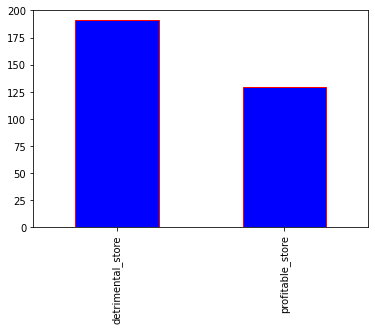

In [28]:
# Plot the distribution of the categories created above:
Y_categorical.value_counts().plot(kind='bar', color='blue', ec='red')

In [29]:
# Randomized hyperparameter search for the random forest classifier:

clasf = RandomForestClassifier()

distributions = {'n_estimators': np.arange(10, 500, 30),
                'max_depth': np.arange(5, 300, 20),
                'min_samples_split': np.arange(2, 10, 1),
                'min_samples_leaf': np.arange(1, 20, 1),
                'min_weight_fraction_leaf': np.arange(0.0, 0.2, 0.01)}

clf = RandomizedSearchCV(clasf, distributions, cv=5, scoring='accuracy', n_iter=50)

search_clasf = clf.fit(data_train, y_train_c)

In [30]:
# Fit model with best hyperparameters:
clasf = search_clasf.best_estimator_

clasf.fit(data_train, y_train_c)

predictions = clasf.predict(data_test)
accuracy_score(y_test_c, predictions)

0.8125

In [31]:
# Refit on the entire data set:
clasf.fit(data_train_full, Y_categorical)

RandomForestClassifier(max_depth=85, min_samples_split=9,
                       min_weight_fraction_leaf=0.03, n_estimators=10)

# Feature importance and performance metrics (Q2 and Q3)

The feature importance determined using the random forests model may be useful for identifying new features to use in future modelling.

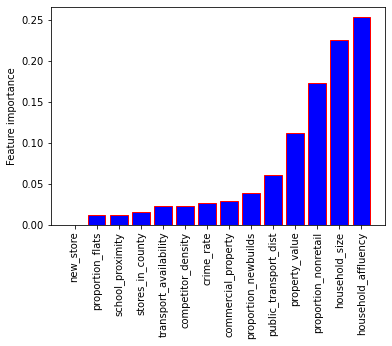

In [32]:
indices = np.argsort(clasf.feature_importances_)
sorted_features = np.array(all_features)[indices]
sorted_feature_importances_ = clasf.feature_importances_[indices]

fig, ax = plt.subplots(1,1,figsize=(6,4))

plot = ax.bar(sorted_features, sorted_feature_importances_, align='center', 
              color='blue', edgecolor='red', label='Average value')
plot = ax.set_ylabel('Feature importance')
plot = plt.xticks(rotation='vertical')

As determined by the random forests model, household affluency and size are the most important features in determining a stores sales. Since both of these features are characteristic of a household, additional features which are descriptive of a household should be considered for future modelling. For example: availability of cars in a household and availability of parking next to a store, average age of household members.

Want to have a small false positive rate: minimize the number of suggestions to open a store in the area which will have
negative sales. Also want a high true positive rate: identify locations to open a store which will be a high seller. To visualise how the model performs I plot the confusion matrix. Then I find the variance of the false positive and true positive rates by performing a stratified cross validation.

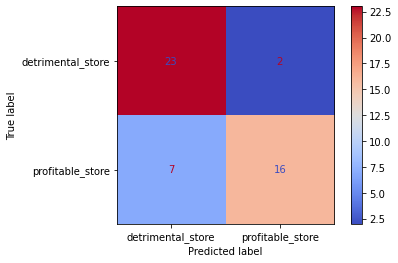

In [33]:
cm = confusion_matrix(y_test_c, predictions, labels=clasf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clasf.classes_)
disp.plot(cmap='coolwarm')

In [34]:
# Find mean false positive and true positive rates. Now I train the model using the full data set. To evaluate model performance
# I use stratified cross validation, which takes into account the uneven distribution of target classes in the data set.
skf = StratifiedKFold(n_splits=15, shuffle=True)

Y_categorical = np.array(Y_categorical)

false_positive_r_container = []
true_positive_r_container = []

for tr_i, te_i in skf.split(data_train_full, Y_categorical):
    clone_clasf = clone(clasf)
    X_train_fold = data_train_full[tr_i]
    X_test_fold = data_train_full[te_i]
    y_train_fold = Y_categorical[tr_i]
    y_test_fold = Y_categorical[te_i]
    
    clone_clasf.fit(X_train_fold, y_train_fold)
    predictions = clone_clasf.predict(X_test_fold)
    cm = confusion_matrix(y_test_fold, predictions)
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    false_positive_r = fp / (fp + tn)
    true_positive_r = tp / (tp + fn)
    false_positive_r_container.append(false_positive_r)
    true_positive_r_container.append(true_positive_r)
    
false_positive_r_container = np.array(false_positive_r_container)
true_positive_r_container = np.array(true_positive_r_container)

print('The false positive rate is {} +/- {}'.format(false_positive_r_container.mean(), false_positive_r_container.std()))
print('The true positive rate is {} +/- {}'.format(true_positive_r_container.mean(), true_positive_r_container.std()))

The false positive rate is 0.09444444444444446 +/- 0.08177258580551244
The true positive rate is 0.7916666666666666 +/- 0.10829771494232182


# Assessing potential new store locations (Q3)

In [35]:
# Predict with regressor:
regression_preds = regr.predict(data_masked)

#Predict with classifier:
classification_preds = clasf.predict(data_masked)

Below is a graph with the predicted stores sales from the masked data set. The columns represent the predicted sales using a random forests regression model. The hollow circles represent the results of the random forests classifier: +1 means the classifier suggests to open a store and -1 that the classifier thinks a store should not be opened.

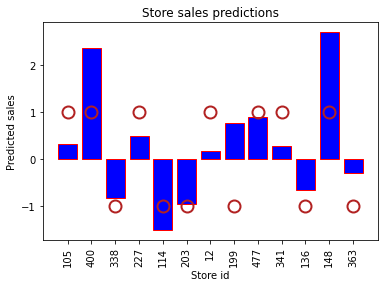

In [36]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

store_id_list = list(map(str, list(test_masked.index))) # Store id list
open_not_open = np.where(classification_preds == 'profitable_store', 1, -1)

plot = ax.bar(store_id_list, regression_preds, align='center', 
              color='blue', edgecolor='red', label='Average value')
plot = ax.set_ylabel('Predicted sales')
plot = ax.plot(store_id_list, open_not_open, 
                   color='firebrick', marker='o', markersize=12, 
                   linestyle = '', fillstyle='none', markeredgewidth=2.0)
plot = ax.set_xlabel('Store id')
plot = plt.xticks(rotation='vertical')
plot = ax.set_title('Store sales predictions')

Both the regression and classification results could be used to decide whether to open a new store. For example store 114 would be a strong no, according to the model. Store 148 would be a strong yes. Store 199 would be inconclusive: the classifier predicts that a store should not be opened while the regressor predicts pretty high normalised sales.

In future developments models such as gradient boosted decision trees could be investigated for improving regression results.

# Q4

Because there are few features, few training examples and little information, in order to reduce the variance 

In [37]:
# Load masked data set:
set2 = pd.read_csv('data//masked_dataset//train.csv')
X_2, y_2 = set2.drop('y', axis=1), set2['y']

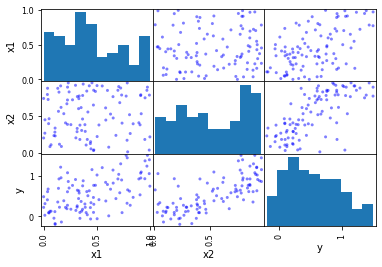

In [38]:
# Look at the scatter matrix:
sm = scatter_matrix(set2, color='blue')

In [39]:
# Get also the correlation matrix
set2.corr()

,x1,x2,y
x1,1.000000,0.061202,0.536305
x2,0.061202,1.000000,0.705965
y,0.536305,0.705965,1.000000


Some correlation between x2 and y! I played with a few combinations of x1 and x2. For example x1 + x2 correlates with y even better:

Correlation coefficient between x1 + x2 and y is 0.8532097688738972


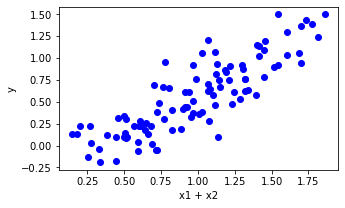

In [40]:
fig, ax = plt.subplots(1,1,figsize=(5,3))

x1_plus_x2 = np.array(X_2)[:, 0] + np.array(X_2)[:, 1]
ax.scatter(x1_plus_x2, y_2,color='blue')
ax.set_xlabel('x1 + x2')
ax.set_ylabel('y')
corr_coeff = np.corrcoef(x1_plus_x2, y_2)[0][1]
print('Correlation coefficient between x1 + x2 and y is {}'.format(corr_coeff))

In [41]:
# The R^2 is not very good for this combination of independent variables.
lr = LinearRegression()
lr.fit(x1_plus_x2.reshape(-1, 1), y_2)

predictions = lr.predict(x1_plus_x2.reshape(-1, 1))
r2 = r2_score(predictions, y_2)
print('R^2 = {}'.format(r2))

R^2 = 0.626311187125845


Lets try to look for the best combination of x1 and x2. I will assume the form a1 * x1 ^ p1 + a2 * x2 ^ p2. Then I find the parameters {a1, a2, p1, p2} by performing a least squares minimization.

In [42]:
def f(x, a1, a2, p1, p2):
    return a1 * x[:, 0] ** p1 + a2 * x[:, 1] ** p2

params, params_covariance = curve_fit(f, np.array(X_2), np.array(y_2))

Correlation coefficient between x1 + x2 and y is 0.8958497834291477


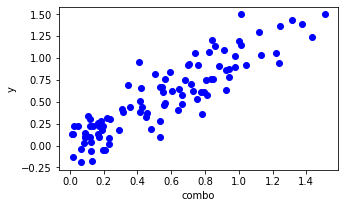

In [43]:
fig, ax = plt.subplots(1,1,figsize=(5,3))

combo = params[0] * np.array(X_2)[:, 0] ** params[2] + params[1] * np.array(X_2)[:, 1] ** params[3]
ax.scatter(combo, y_2,color='blue')
ax.set_xlabel('combo')
ax.set_ylabel('y')
corr_coeff = np.corrcoef(combo, y_2)[0][1]
print('Correlation coefficient between x1 + x2 and y is {}'.format(corr_coeff))

In [44]:
lr = LinearRegression()
lr.fit(combo.reshape(-1, 1), y_2)

predictions = lr.predict(combo.reshape(-1, 1))
r2 = r2_score(predictions, y_2)
print('Optimal x1 and x2 combo R^2 = {}'.format(r2))

Optimal x1 and x2 combo R^2 = 0.753966800379526


By combining the two features in the above manner leads to a pretty good linear model. It is pretty simple (high bias), which is good considering the lack of data and information. The simplicity gives confidence that the variance of the model will be low. For the range of x1 and x2 values which were in the data set, the model could be applied to new instances of x1 and x2 to make predictions of y or at least the expected trend. I would be more cautious about extrapolating prediction values outside this range.